# PART 2 : GLM

In [1]:
import pandas as pd
import numpy as np
from nilearn.glm.first_level import make_first_level_design_matrix
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix, plot_anat
from nilearn.glm.first_level import FirstLevelModel
import nibabel as nib

from nilearn.plotting import plot_contrast_matrix
import nibabel as nib
import os

from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img


## 1. Get event information

In [2]:
# experimental design 
events_all = pd.DataFrame()

for id_run in range(3) : 
    events_files = f'gdrive_ds000171/ds000171/sub-control01/func/sub-control01_task-music_run-{id_run+1}_events.tsv'
    
    event = pd.read_csv(events_files, sep='\t')
    event.insert(0, 'run', f'run_{id_run+1}')
    
    events_all = pd.concat((events_all, event))

In [3]:
# Take the information from the json file to find TR
task_music_json = 'gdrive_ds000171/ds000171/task-music_bold.json'

import json

# Open and read the JSON file
with open(task_music_json, 'r') as file:
    info = json.load(file)

# Import TR
TR = info['RepetitionTime']

In [4]:
# inspect the events datafram 
events_all

,run,onset,duration,trial_type
0,run_1,0.0,33.0,tones
1,run_1,33.0,3.0,response
2,run_1,36.0,31.5,negative_music
3,run_1,67.5,3.0,response
4,run_1,70.5,31.5,tones
5,run_1,102.0,3.0,response
6,run_1,105.0,31.5,positive_music
7,run_1,136.5,3.0,response
8,run_1,139.5,31.5,tones
9,run_1,171.0,3.0,response


## 2. Building design matrix

In [5]:
# Adjust the oneset for all the runs
duration_time ={}
for i in range(3) : 
    last_event = events_all[events_all['run'] == f'run_{i+1}'].tail(1)
    duration_time[i] = last_event['onset'].values + last_event['duration'].values

size_single_run =  len(events_all[events_all['run'] == f'run_1'])  # Here we takes the first but all of them are the same size

correction=[]
for i in range(3):  
    correction += [duration_time[i][0]*i]*size_single_run

events_all['onset'] += correction
# Drop the response recording  
#events = events_all.query("trial_type != 'response'")
# Drop the index of the run

events = events_all.drop(columns = 'run')

In [6]:
t_start = events['onset'][0]
t_end =events.tail(1)['onset'] + events.tail(1)['duration']

frame_times= np.asarray(list(range(int(t_start.values[0]), int(t_end.values[0]), int(TR))))

Text(0.5, 1.0, 'Design Matrix for 3 Concatenated Runs')

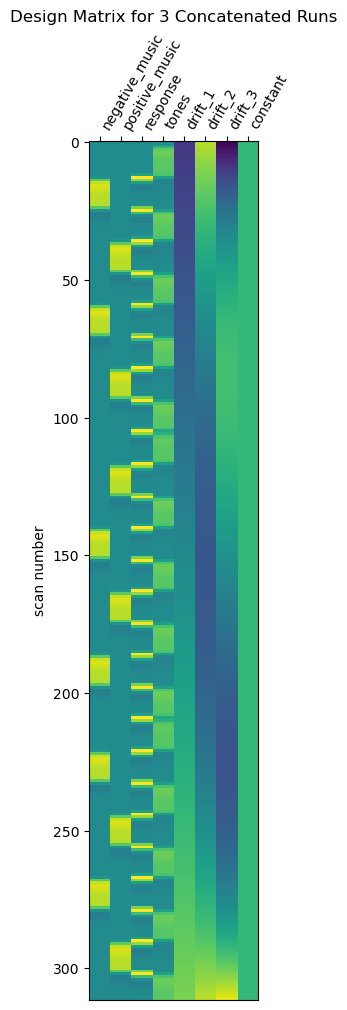

In [7]:
# Create design matrix using specified HRF model
design_matrix_conc = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events,
    hrf_model='spm', # TODO
    drift_model='polynomial',  
    drift_order=3
)

plot_design_matrix(design_matrix_conc)
plt.title("Design Matrix for 3 Concatenated Runs")

## 3. Initialize the GLM

In [9]:
# Import data from preproc
data_path = 'derivatives/sub_control01_preprocessed/func/concatenated_standardized_mc_smoothed.nii.gz'

fmri_img=nib.load(data_path)

In [ ]:
from nilearn.glm.first_level import FirstLevelModel
drift_model = 'polynomial'  # Model to correct for slow signal drifts 
high_pass =0.01

# Initialize the GLM model with drift correction and AR(1) noise model
fmri_glm = FirstLevelModel(
    t_r=TR,
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model=drift_model,
    high_pass=high_pass, 
    drift_order=3
)

In [11]:
fmri_glm = fmri_glm.fit(fmri_img, events)

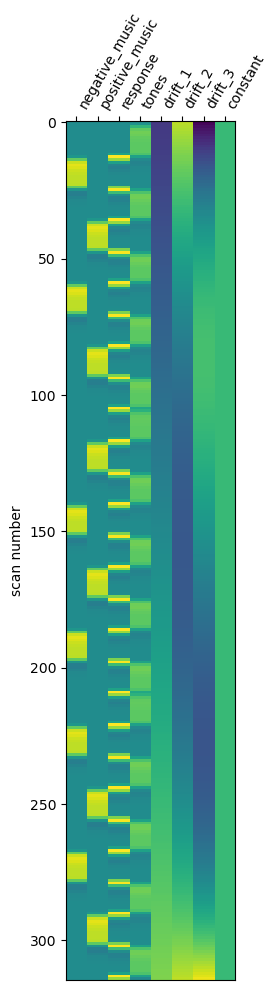

In [43]:
# we got the same matrix than previously
plot_design_matrix(fmri_glm.design_matrices_[0])

# Save the matrix 
plt.savefig('data_visu/design_matrix_GLM.png')


## 4. Get the contrasts and the z-map associated 

In [30]:
# Create the dictionary of the conditions
conditions = {
    'neg_music' : np.array([1, 0, 0, 0 , 0, 0, 0, 0]),
    'pos_music' : np.array([0, 1, 0, 0 , 0, 0, 0, 0]),
    'tones' : np.array([0, 0, 0, 1, 0, 0, 0, 0]),
    'drift' : np.array([0, 0, 0, 0, 1/3, 1/3, 1/3, 0])
}
# drift
drift = conditions['drift']

# Effect of negative musique 
neg_effect = conditions['tones'] - conditions['neg_music'] 

# Effect of positive musique 
pos_effect = conditions['tones'] - conditions['pos_music'] 

# positive versus negative musique
pos_neg = conditions['pos_music'] - conditions['neg_music'] 


In [31]:
# To got the names of the varriable - put in utile
from helper import namestr

for contrast in [neg_effect,pos_effect,pos_neg,drift] :
    print(namestr(contrast, globals()))


['neg_effect', 'contrast']
['pos_effect', 'contrast']
['pos_neg', 'contrast']
['drift', 'contrast']


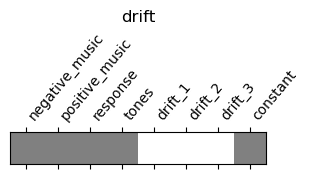

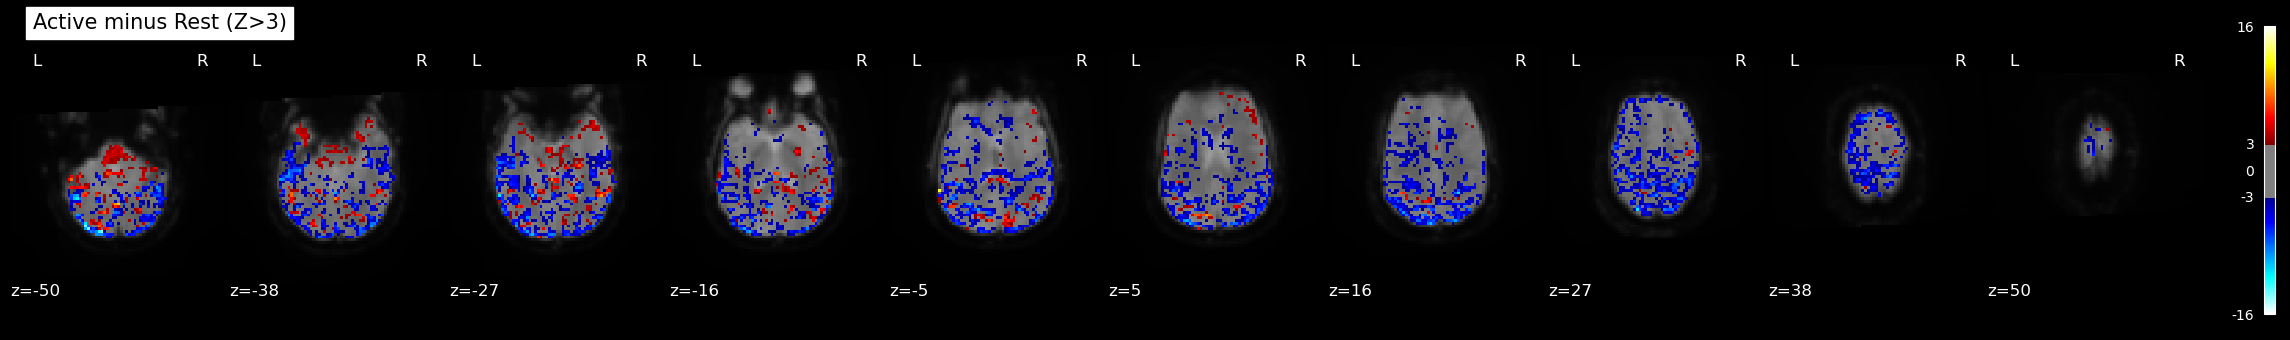

In [44]:
# First examine the drift to eventually correct the image
folder_state_path = 'derivatives/stats/z_maps'

# Plot the contrast map
plot_contrast_matrix(drift, design_matrix=fmri_glm.design_matrices_[0])
plt.title(namestr(drift, globals())[0])

# z map 
z_map = fmri_glm.compute_contrast(drift, output_type='z_score')

# plot z map 
mean_img_ = mean_img(fmri_img),
thr = 3

plot_stat_map(z_map, bg_img=mean_img_[0], threshold=thr,
              display_mode='z', cut_coords= np.linspace(-50,50, 10), black_bg=True,
              title=f'Active minus Rest (Z>{thr})')

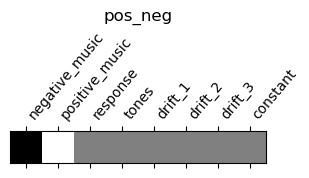

In [46]:
# Create a directory to save the z_map
folder_state_path = 'derivatives/GLM/z_maps'

if not os.path.exists(folder_state_path):
    os.makedirs(folder_state_path)

for contrast in [pos_neg] : #[neg_effect,pos_effect,pos_neg]:
    # Plot the contrast map
    plot_contrast_matrix(contrast, design_matrix=fmri_glm.design_matrices_[0])
    plt.title(namestr(contrast, globals())[0])

    # z map 
    z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')

    # Save the z_map uncorrected
    file_name = namestr(contrast, globals())[0] + '_z_map_uncorrected.nii.gz'
    nib.save(z_map, os.path.join(folder_state_path, file_name))



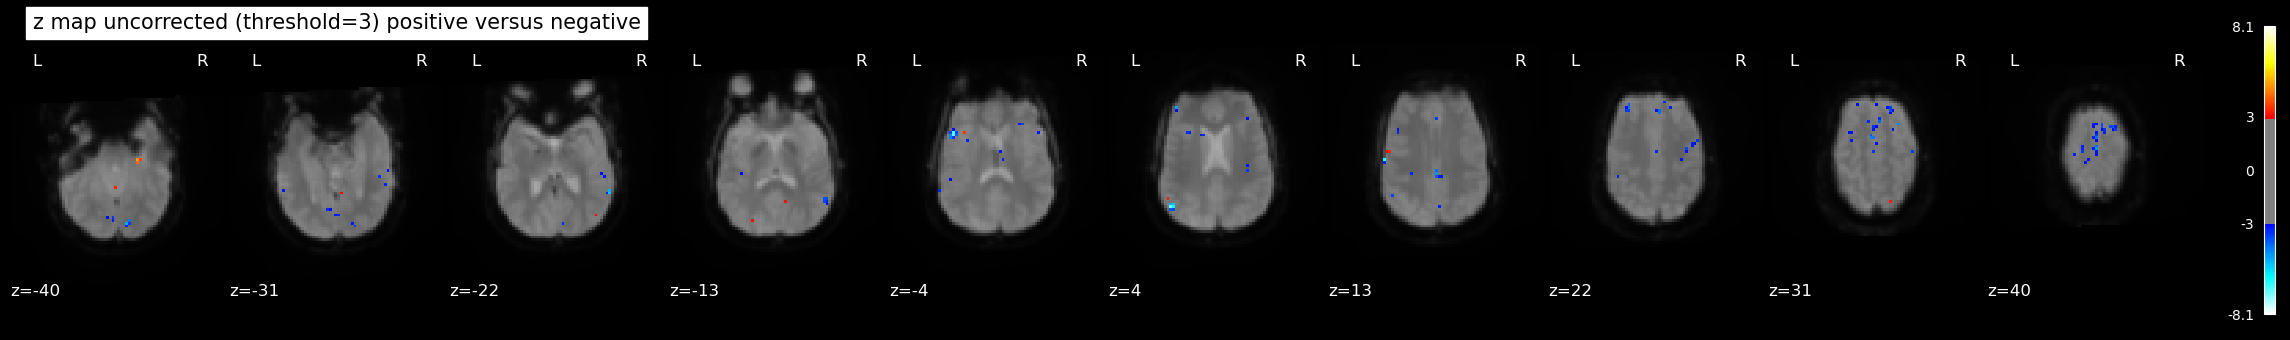

In [73]:
# explore the z_map 
z_map = nib.load(os.path.join(folder_state_path, 'pos_neg_z_map_uncorrected.nii.gz'))
mean_img_ = mean_img(fmri_img),
thr = 3
plot_stat_map(z_map, bg_img=mean_img_[0],  
              display_mode='z',
              black_bg=True,
              threshold=thr,
              cut_coords=  np.linspace(-40,40, 10), 
              title='z map uncorrected (threshold={}) positive versus negative'.format(thr)) 

plt.savefig(os.path.join(folder_state_path, 'pos_neg_z_map_uncorrected.png'))
plt.show()

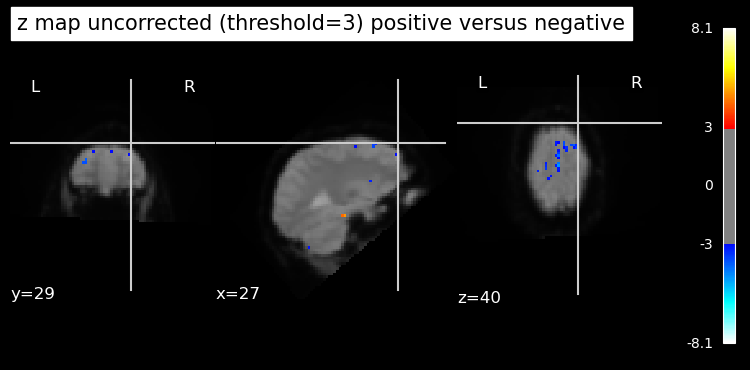

In [79]:
# More precise view
plot_stat_map(z_map, bg_img=mean_img_[0],  
              display_mode='ortho',
              black_bg=True,
              threshold=thr,
              cut_coords=  [ 27.6, 29.5, 40.47], 
              title='z map uncorrected (threshold={}) positive versus negative'.format(thr)) 
plt.show()

## Statistical correction with fdr

In [68]:
threshold

4.463449429144451

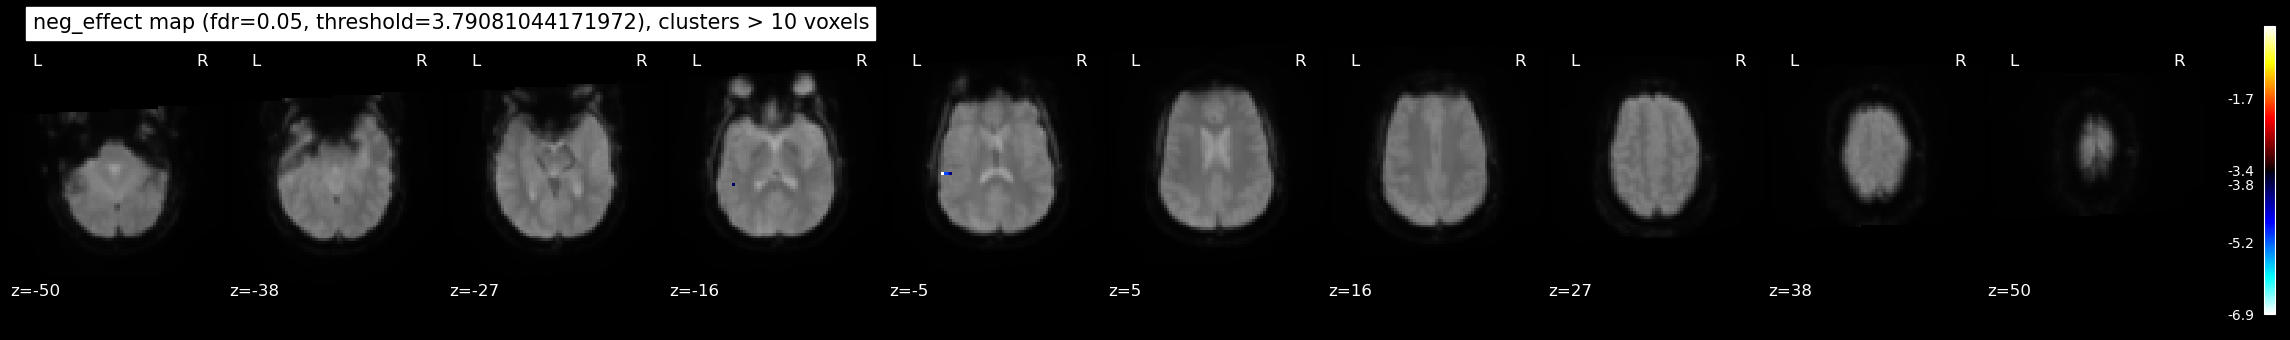

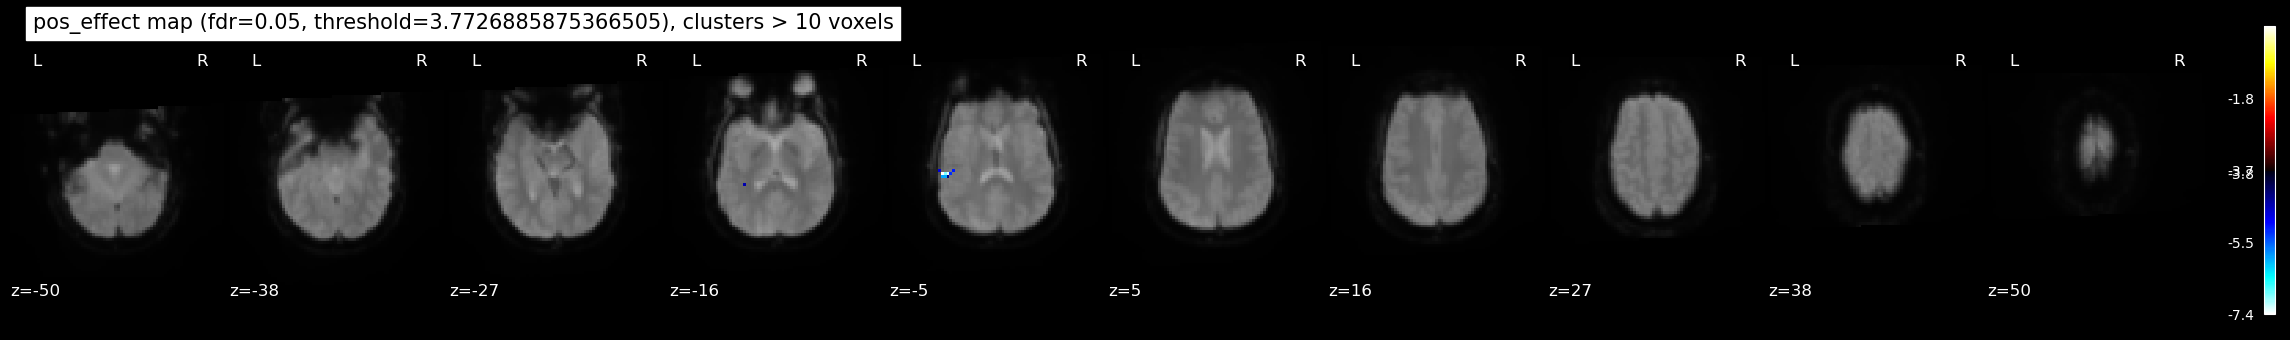

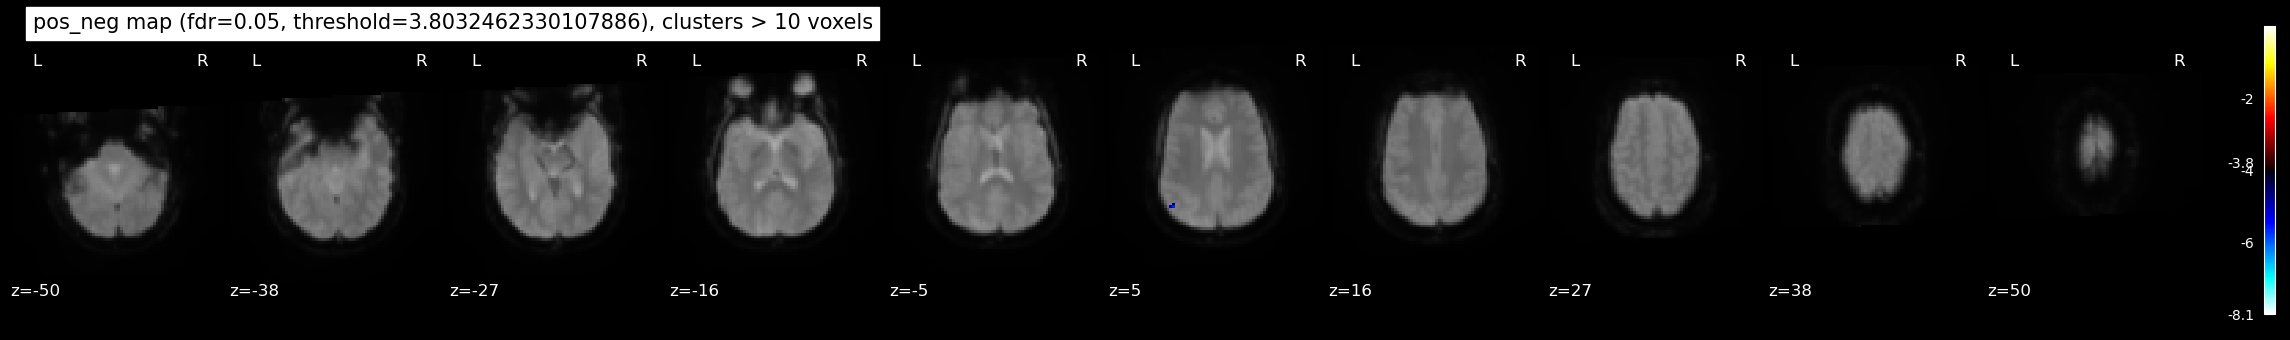

In [86]:
from nilearn.glm import threshold_stats_img

cluster_size = 10 
fdr_rate = 0.05


for contrast in [neg_effect,pos_effect,pos_neg]:
    # Load z_map the z_map uncorrected
    file_name = namestr(contrast, globals())[0] + '_z_map_uncorrected.nii.gz'
    z_map = nib.load(os.path.join(folder_state_path, file_name))

    # FDR correction + threshold
    clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size, two_sided=True)

    # Save the clean map
    file_name = namestr(contrast, globals())[0] + '_z_map_clean.nii.gz'
    nib.save(clean_map, os.path.join(folder_state_path, file_name))


    plot_title = namestr(contrast, globals())[0]

    plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=-threshold, 
                display_mode='z', cut_coords= np.linspace(-50, 50, 10), black_bg=True, 
                title='{} map (fdr={}, threshold={}), clusters > {} voxels'.format(plot_title, fdr_rate, threshold, cluster_size))
    plt.show()

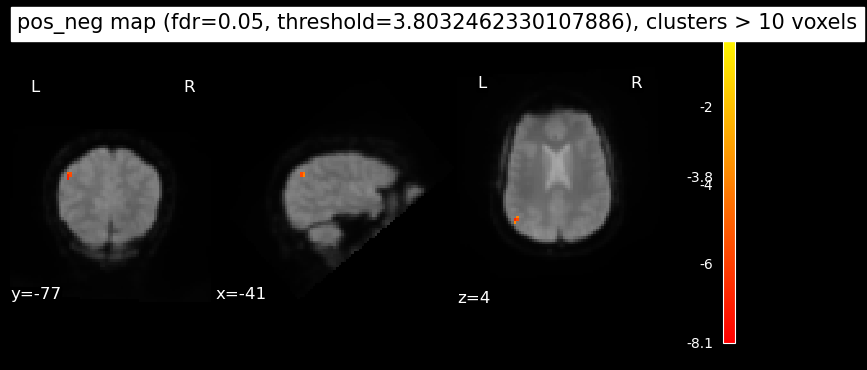

In [ ]:
# Better view
plot_stat_map(clean_map, bg_img=mean_img_[0],  
              display_mode='ortho',
              black_bg=True,
              threshold=-threshold,
              cut_coords=  [-41.49, -77.97, 4.298], 
              title='{} map (fdr={}, threshold={}), clusters > {} voxels'.format(plot_title, fdr_rate, threshold, cluster_size),
              cmap = 'autumn', 
              draw_cross=False)
plt.savefig(os.path.join(folder_state_path, 'pos_neg_z_map_clean.png'))
plt.show()

In [ ]:
# Atlas comparision 
# use AAL3 from https://www.gin.cnrs.fr/en/tools/aal/ on MNI template:
#  An automated anatomical parcellation of the spatially normalized single-subject high-resolution T1 
# volume provided by the Montreal Neurological Institute (MNI) and an alternative parcellation of the orbitofrontal 
# cortex (AAL2), the anterior cingulate, the thalamus, with the addition of some brain nuclei (AAL3).

atlas_path = 'MNI/MNI152_T1_1mm.nii.gz'
parc_path ='MNI/AAL3v1_1mm.nii.gz'
atlas = nib.load(atlas_path)
parc = nib.load(parc_path)


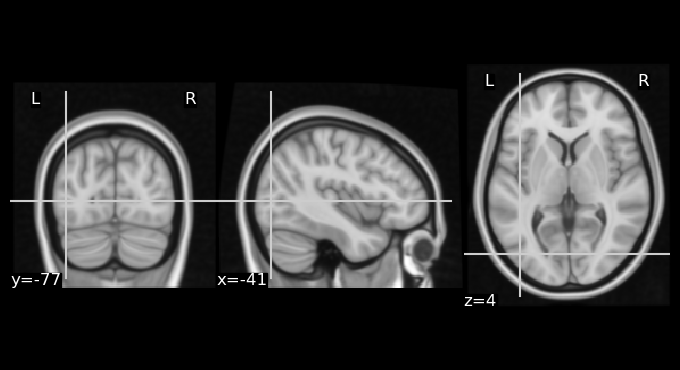

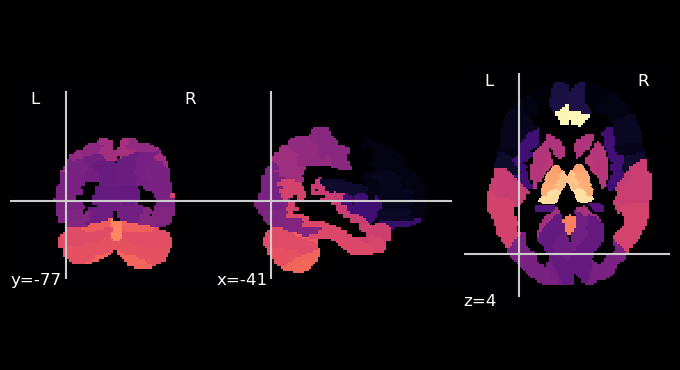

In [126]:
from nilearn import plotting
# Plot the atlas 
plotting.plot_img(atlas, cmap='grey', black_bg=True, cut_coords=  [-41.49, -77.97, 4.298])

# plot the parcellation
plotting.plot_img(parc, cmap='magma', black_bg=True, cut_coords=  [-41.49, -77.97, 4.298])

By moving around with the visualization tool we can associate this high difference of activity to the  parietal inferior left area of the MNI parcellation (label 65) but we should have use a registration to MNI space on our functional data or a run a parcellation algorithm such as free surfer to be sure and more precise about the label assignment.